## Reading Input and loading required libraries

In [ ]:
#Please upload the file here
from google.colab import files
uploaded = files.upload()

Saving Sentiment140.tenPercent.sample.tweets.tsv to Sentiment140.tenPercent.sample.tweets.tsv


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Reading and looking at the data
data =pd.read_csv('/content/Sentiment140.tenPercent.sample.tweets.tsv', sep= '\t')
data

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,4,@Covergirl08 I take pride in what I do
159998,4,heading to work on the 6


In [ ]:
# looking for null values
data.isnull().sum() # data doesnt have any null values

sentiment_label    0
tweet_text         0
dtype: int64

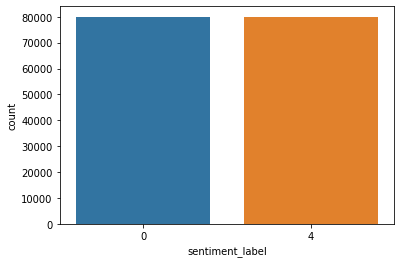

In [ ]:
# Looking at the distribution of target classses
sns.countplot(data=data, x='sentiment_label')

In [ ]:
# Converting positive sentiments '4' to 1 and negative sentiments '0' as 0
def convert(x):
    if x == 4:
        return 1
    else:
        return 0
    
y = data['sentiment_label'].apply(lambda x: convert(x))

## Data Preprocessing

### 1. Removing HTML tags, punctuations, numbers, single characters and multiple spaces

In [ ]:
#Removing HTML tags
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
def preprocess_text(sen):
  # coverting into lower case
  sentence = sen.lower()

  # Removing html tags
  sentence = remove_tags(sentence)

  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  # Single character removal of 'a'
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence

In [ ]:
# Storing all the cleaned tweets data in variable X
X = []
sentences = list(data['tweet_text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Splitting the data into trainign and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=12)

###2. Tokenization 

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

###3. Word Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-02-14 22:04:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-14 22:04:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-14 22:04:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Building Machine Learning Models

### 1. Dense Model

In [ ]:
# The first model is a simple sequential Dense model

#Defining model
model = Sequential() 

#adding layers
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen)),
model.add(GlobalAveragePooling1D()),
model.add(Dense(40, activation='relu')),
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu')),
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu')),
model.add(Dense(5, activation='relu')),

#output layer
model.add(Dense(1, activation='sigmoid'))

#compiling layer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

callbacks = [EarlyStopping(monitor="val_loss", patience=1),ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 100, 100)          10633400  
                                                                 
 global_average_pooling1d_10  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_83 (Dense)            (None, 40)                4040      
                                                                 
 dropout_31 (Dropout)        (None, 40)                0         
                                                                 
 dense_84 (Dense)            (None, 10)                410       
                                                                 
 dropout_32 (Dropout)        (None, 10)                0         
                                                     

In [ ]:
model.fit(X_train, y_train, batch_size=2000, epochs=20, verbose=1, validation_split=0.2, callbacks=callbacks)

Epoch 1/20
52/52 [==============================] - 5s 63ms/step - loss: 0.6918 - acc: 0.5230 - val_loss: 0.6896 - val_acc: 0.5652
Epoch 2/20
52/52 [==============================] - 2s 48ms/step - loss: 0.6807 - acc: 0.5916 - val_loss: 0.6557 - val_acc: 0.6585
Epoch 3/20
52/52 [==============================] - 2s 42ms/step - loss: 0.6350 - acc: 0.6976 - val_loss: 0.5975 - val_acc: 0.7252
Epoch 4/20
52/52 [==============================] - 2s 42ms/step - loss: 0.5927 - acc: 0.7463 - val_loss: 0.5741 - val_acc: 0.7593
Epoch 5/20
52/52 [==============================] - 2s 41ms/step - loss: 0.5645 - acc: 0.7679 - val_loss: 0.5571 - val_acc: 0.7689
Epoch 6/20
52/52 [==============================] - 2s 41ms/step - loss: 0.5458 - acc: 0.7793 - val_loss: 0.5489 - val_acc: 0.7662
Epoch 7/20
52/52 [==============================] - 2s 41ms/step - loss: 0.5276 - acc: 0.7903 - val_loss: 0.5369 - val_acc: 0.7771
Epoch 8/20
52/52 [==============================] - 2s 41ms/step - loss: 0.5140 - a

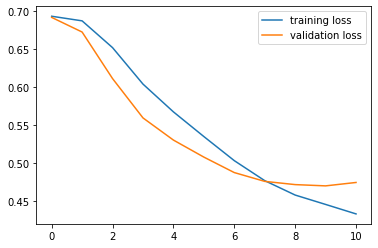

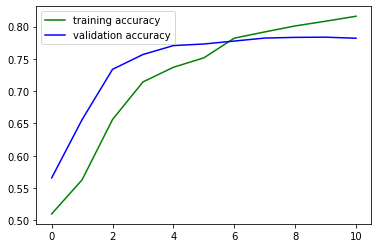

In [ ]:
#Plotting loss and accuracy of training and validation sets
df = pd.DataFrame(model.history.history)
# plotting loss
plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.legend(['training loss','validation loss'])
plt.show()

#plotting accuracy
plt.plot(df['acc'],color = 'green')
plt.plot(df['val_acc'], color='blue')
plt.legend(['training accuracy','validation accuracy'])
plt.show()

In [ ]:

# Evaluating model's loss, accuracy on Training and Testing data
train  = model.evaluate(X_train, y_train,verbose=0)
print('Model loss on training data is : ',round(train[0],2))
print('Model accuracy on training data is : ',round(train[1]*100,2),'%')
print()
test  = model.evaluate(X_test, y_test,verbose=0)
print('Model loss on testing data is : ',round(test[0],2))
print('Model accuracy on testing data is : ',round(test[1]*100,2),'%')

Model loss on training data is :  0.49
Model accuracy on training data is :  80.25 %

Model loss on testing data is :  0.53
Model accuracy on testing data is :  76.09 %


####Performance evaluation

In [ ]:
# Classification report for precision,reaccl,f1-score of each class, and accuracy of over all model

y_pred = (model.predict(X_test)).round().astype("int32")
print(classification_report(y_test, y_pred))

#confusion matrix
print('Confusion matrix : ')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77     15869
           1       0.76      0.81      0.79     16131

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000

Confusion matrix : 
[[11834  4035]
 [ 3050 13081]]


In [ ]:
# AUC Score of the model
auc_score = roc_auc_score(y_test, model.predict(X_test))
print('AUC score of the model is :',round(auc_score,3))

# roc curve for models
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

AUC score of the model is : 0.853


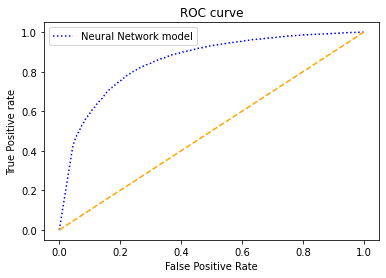

In [ ]:
# Plotting ROC Curve
plt.plot(fpr, tpr,color='blue',linestyle=':')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(['Neural Network model'],loc='best')
plt.show()

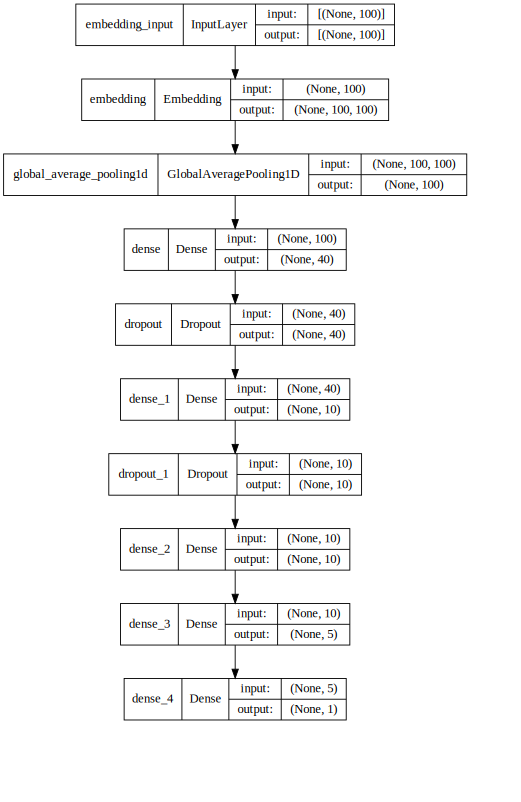

In [ ]:
# Visualize network architecture
SVG(model_to_dot(model, show_shapes=True,show_layer_names=True, dpi=65).create(prog="dot", format="svg"))

###2. CNN model

In [ ]:
#Defining the model
model = Sequential() 

#Hidden layers
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen))
model.add(Conv1D(100, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))

#Output layer
model.add(Dense(1, activation='sigmoid'))

#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

callbacks = [EarlyStopping(monitor="val_loss", patience=1),ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 100, 100)          10633400  
                                                                 
 conv1d_11 (Conv1D)          (None, 96, 100)           50100     
                                                                 
 global_max_pooling1d_11 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_88 (Dense)            (None, 10)                1010      
                                                                 
 dropout_33 (Dropout)        (None, 10)                0         
                                                                 
 dense_89 (Dense)            (None, 10)                110       
                                                     

In [ ]:
model.fit(X_train, y_train, batch_size=2000, epochs=20, verbose=1, validation_split=0.2, callbacks=callbacks)

Epoch 1/20
52/52 [==============================] - 7s 128ms/step - loss: 0.6469 - acc: 0.6179 - val_loss: 0.5688 - val_acc: 0.7164
Epoch 2/20
52/52 [==============================] - 6s 125ms/step - loss: 0.5657 - acc: 0.7157 - val_loss: 0.5160 - val_acc: 0.7541
Epoch 3/20
52/52 [==============================] - 7s 128ms/step - loss: 0.5161 - acc: 0.7527 - val_loss: 0.4901 - val_acc: 0.7709
Epoch 4/20
52/52 [==============================] - 6s 125ms/step - loss: 0.4847 - acc: 0.7719 - val_loss: 0.4796 - val_acc: 0.7748
Epoch 5/20
52/52 [==============================] - 6s 124ms/step - loss: 0.4607 - acc: 0.7882 - val_loss: 0.4746 - val_acc: 0.7803
Epoch 6/20
52/52 [==============================] - 7s 125ms/step - loss: 0.4391 - acc: 0.8019 - val_loss: 0.4654 - val_acc: 0.7829
Epoch 7/20
52/52 [==============================] - 7s 130ms/step - loss: 0.4202 - acc: 0.8128 - val_loss: 0.4635 - val_acc: 0.7821
Epoch 8/20
52/52 [==============================] - 6s 124ms/step - loss: 0.

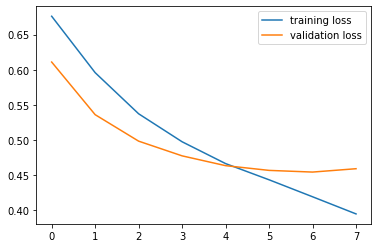

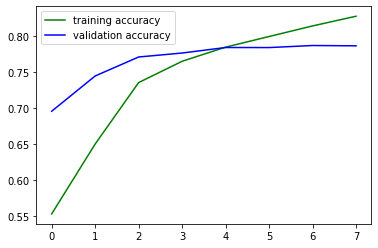

In [ ]:
#Plotting loss and accuracy of training and validation sets
df = pd.DataFrame(model.history.history)
# plotting loss
plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.legend(['training loss','validation loss'])
plt.show()

#plotting accuracy
plt.plot(df['acc'],color = 'green')
plt.plot(df['val_acc'], color='blue')
plt.legend(['training accuracy','validation accuracy'])
plt.show()

In [ ]:
# Evaluating model's loss, accuracy on Training and Testing data
train  = model.evaluate(X_train, y_train,verbose=0)
print('Model loss on training data is : ',round(train[0],2))
print('Model accuracy on training data is : ',round(train[1]*100,2),'%')
print()
test  = model.evaluate(X_test, y_test,verbose=0)
print('Model loss on testing data is : ',round(test[0],2))
print('Model accuracy on testing data is : ',round(test[1]*100,2),'%')

Model loss on training data is :  0.35
Model accuracy on training data is :  86.03 %

Model loss on testing data is :  0.47
Model accuracy on testing data is :  77.89 %


#### Performance evaluation

In [ ]:
# Classification report for precision,reaccl,f1-score of each class, and accuracy of over all model

y_pred = (model.predict(X_test)).round().astype("int32")
print(classification_report(y_test, y_pred))

#confusion matrix
print('Confusion matrix : ')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77     15869
           1       0.76      0.83      0.79     16131

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000

Confusion matrix : 
[[11600  4269]
 [ 2788 13343]]


In [ ]:
# AUC Score of the model
auc_score = roc_auc_score(y_test, model.predict(X_test))
print('AUC score of the model is :',round(auc_score,3))

# roc curve for models
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

AUC score of the model is : 0.865


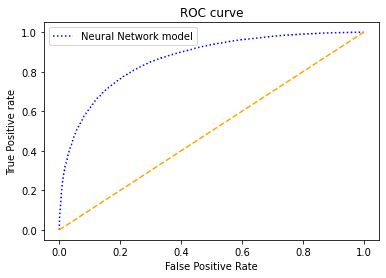

In [ ]:
# Plotting ROC Curve
plt.plot(fpr, tpr,color='blue',linestyle=':')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(['Neural Network model'],loc='best')
plt.show()

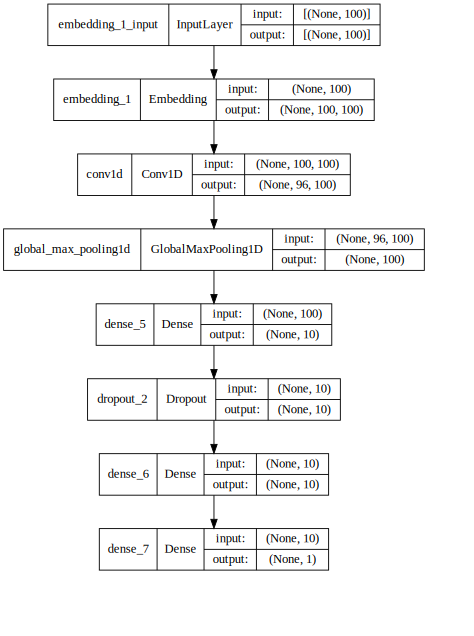

In [ ]:
# Visualize network architecture
SVG(model_to_dot(model, show_shapes=True,show_layer_names=True, dpi=65).create(prog="dot", format="svg"))